In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [3]:
print(torch.cuda.is_available())

True


In [4]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])

In [5]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
# df['EMA_4h'] = df['Price'].ewm(span=48, adjust=False).mean()


df['SMA_4h'] = df['Price'].shift(1).rolling(window=48).mean()
# df['EMA_1d'] = df['Price'].ewm(span=288, adjust=False).mean()
df['Forecast_difference_0.5 hour future'] = df['Forecast_Roof_0.5 hour future'] - df['Forecast_Demand_0.5 hour future']
df["Forecast_ratio_0.5 hour future"] = df['Forecast_Roof_0.5 hour future'] / df['Forecast_Demand_0.5 hour future']
df.set_index('date', inplace=True)
df['Demand_lag1'] = df['Demand'].shift(1)  
df['Actual_Demand_OPERATIONAL_DEMAND_lag1'] = df['Actual_Demand_OPERATIONAL_DEMAND'].shift(1)  


df = df.drop(['Demand', 'Actual_Demand_OPERATIONAL_DEMAND'], axis=1)

# 去除第一行的 NaN 值（因為移動了一步，第一行的滯後特徵會是空的）
df = df.dropna()

In [6]:

df = df.drop(columns=['Region', 'Actual_Roof_OPOWER', 'Actual_Roof_LASTCHANGED'])


In [7]:
from datetime import datetime, time

def create_qld_holidays_list():
    holidays = [
        # 2023
        "2023-01-01", "2023-01-02", "2023-01-26", "2023-04-07", "2023-04-08", "2023-04-09", "2023-04-10",
        "2023-04-25", "2023-05-01", "2023-08-16", "2023-10-02", "2023-12-25", "2023-12-26",
        # 2024
        "2024-01-01", "2024-01-26", "2024-03-29", "2024-03-30", "2024-03-31", "2024-04-01",
        "2024-04-25", "2024-05-06", "2024-08-14", "2024-10-07", "2024-12-25", "2024-12-26",
        # 2025
        "2025-01-01", "2025-01-27", "2025-04-18", "2025-04-19", "2025-04-20", "2025-04-21",
        "2025-04-25", "2025-05-05", "2025-08-13", "2025-10-06", "2025-12-25", "2025-12-26"
    ]
    return pd.to_datetime(holidays)

def add_qld_holidays(df):
    holidays = create_qld_holidays_list()
    
   
    df['is_holiday'] = 0
    
    df.loc[df.index.isin(holidays), 'is_holiday'] = 1
    
    
    return df

In [8]:
df = add_qld_holidays(df)

In [9]:
X = df.drop('Price', axis=1)
y = df['Price']

train_end_date = pd.to_datetime("2024-04-30 23:59:59")
val_end_date = pd.to_datetime("2024-05-31 23:59:59")
test_start_date = pd.to_datetime("2024-06-01 00:00:00")


X_train = X[X.index <= train_end_date]
X_val = X[(X.index > train_end_date) & (X.index <= val_end_date)]
X_test = X[X.index >= test_start_date]

y_train = y[y.index <= train_end_date]
y_val = y[(y.index > train_end_date) & (y.index <= val_end_date)]
y_test = y[y.index >= test_start_date]

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [11]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=20000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]    

In [12]:
class TransAm(nn.Module):
    def __init__(self, feature_size=50, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        batch_size, seq_length, _ = src.size()
        if self.src_mask is None or self.src_mask.size(0) != seq_length:
            device = src.device
            mask = self._generate_square_subsequent_mask(seq_length).to(device)  # 使用序列長度生成掩碼
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [13]:
def prepare_data(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i:i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10


X_train_seq, y_train_seq = prepare_data(X_train, y_train, seq_length)
X_val_seq, y_val_seq = prepare_data(X_val, y_val, seq_length)
X_test_seq, y_test_seq = prepare_data(X_test, y_test, seq_length)

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)


In [15]:
import math
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

# 超參數
input_size = X_train_tensor.shape[2]  
hidden_size = 128
num_layers = 3
num_epochs = 50
batch_size = 32
learning_rate = 0.002
num_heads = 8

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 區塊 6：初始化模型


model = TransAm(feature_size=input_size).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


c:\Users\Owner\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:

import numpy as np
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
best_val_loss = float('inf')


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        
        loss = criterion(outputs.squeeze(), batch_y)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
        
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    
    # Validation
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')


c:\Users\Owner\anaconda3\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/50, Train Loss: 51.271971, Val Loss: 47.234866
Epoch 2/50, Train Loss: 45.381734, Val Loss: 43.671530
Epoch 3/50, Train Loss: 44.606228, Val Loss: 42.376159
Epoch 4/50, Train Loss: 44.213816, Val Loss: 41.131616
Epoch 5/50, Train Loss: 43.913776, Val Loss: 40.685028
Epoch 6/50, Train Loss: 43.706592, Val Loss: 40.036596
Epoch 7/50, Train Loss: 43.522112, Val Loss: 39.734831
Epoch 8/50, Train Loss: 43.285966, Val Loss: 39.204464
Epoch 9/50, Train Loss: 43.120352, Val Loss: 38.775356
Epoch 10/50, Train Loss: 42.937210, Val Loss: 38.215156
Epoch 11/50, Train Loss: 42.810482, Val Loss: 38.172967
Epoch 12/50, Train Loss: 42.689152, Val Loss: 38.067807
Epoch 13/50, Train Loss: 42.612187, Val Loss: 37.568878
Epoch 14/50, Train Loss: 42.507867, Val Loss: 37.446195
Epoch 15/50, Train Loss: 42.418919, Val Loss: 37.226384
Epoch 16/50, Train Loss: 42.338186, Val Loss: 36.942995
Epoch 17/50, Train Loss: 42.234968, Val Loss: 36.898240
Epoch 18/50, Train Loss: 42.128993, Val Loss: 36.713292
E

In [200]:
torch.save(model.state_dict(), 'trans_am_model.pth')

print("Model saved as 'trans_am_model.pth'.")

Model saved as 'trans_am_model.pth'.


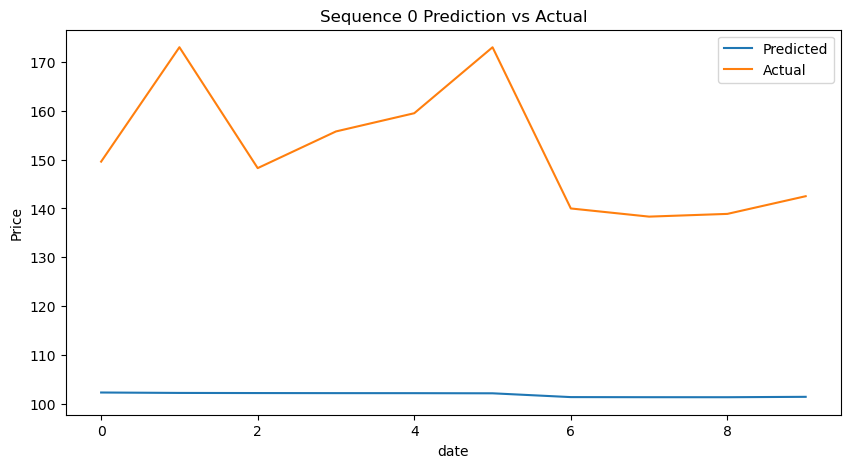

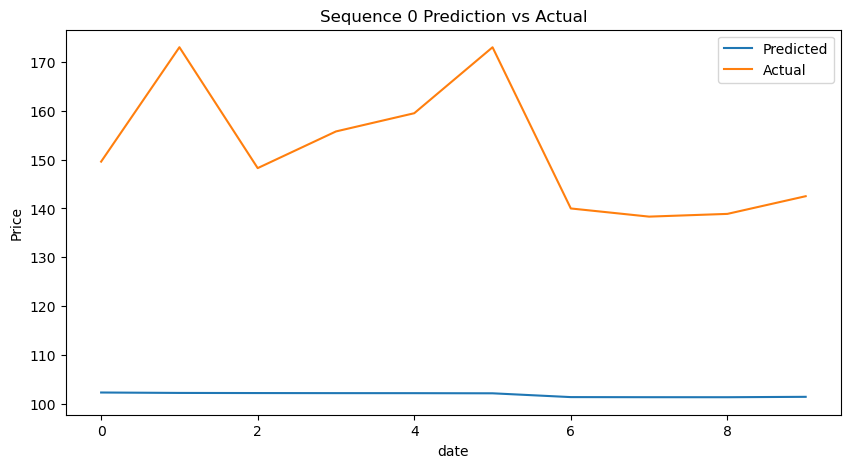

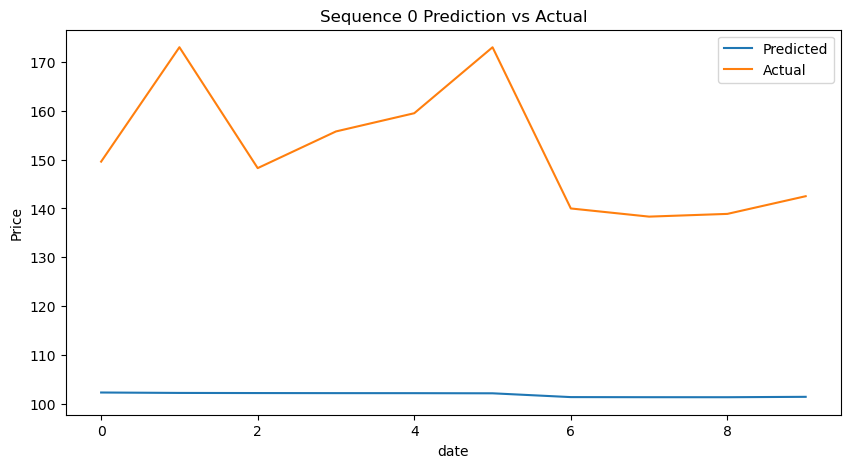

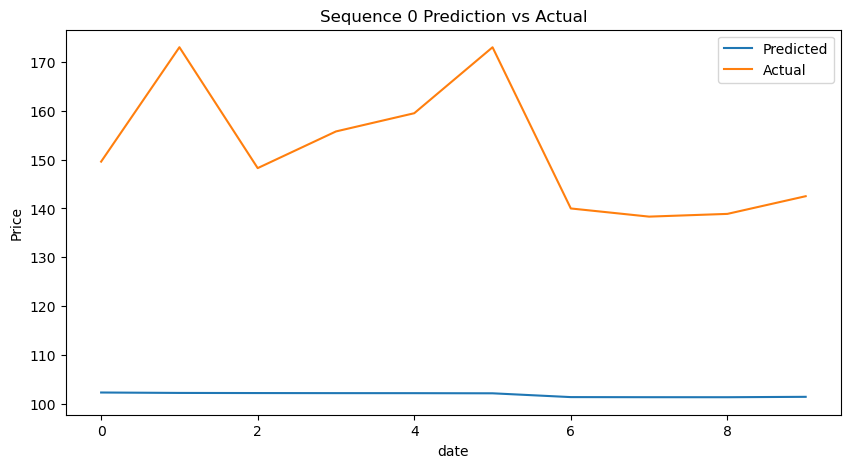

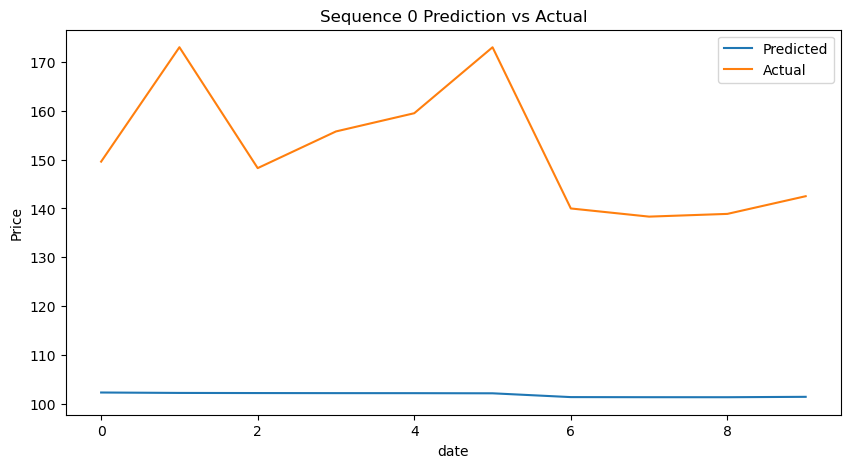

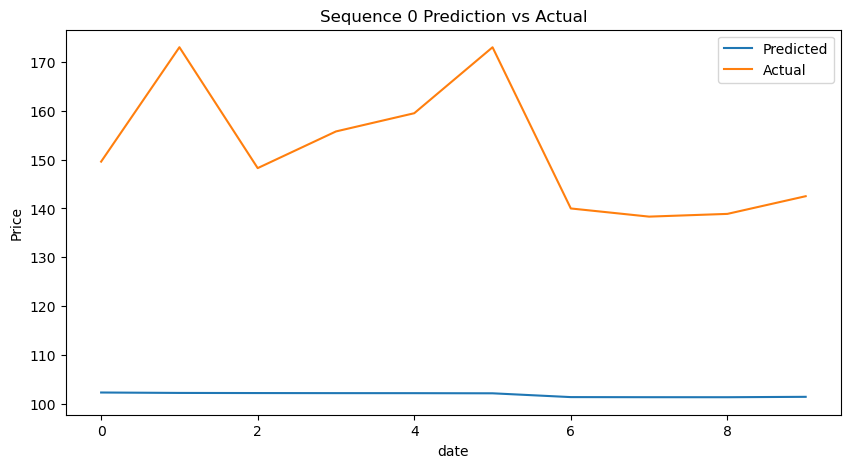

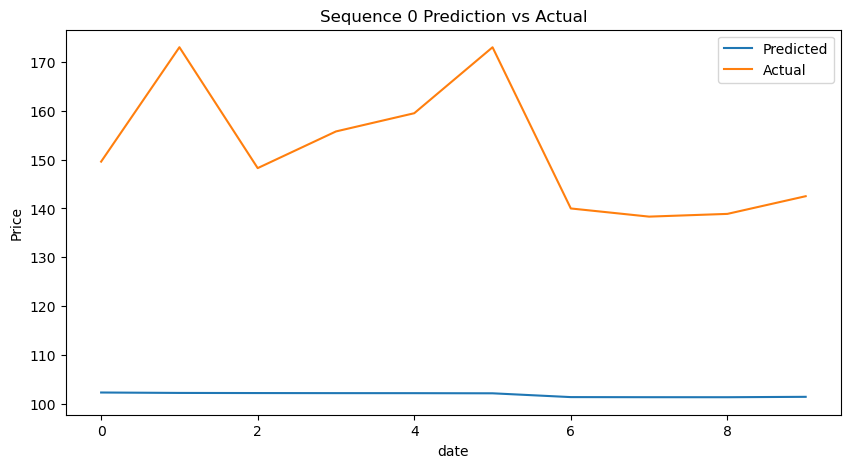

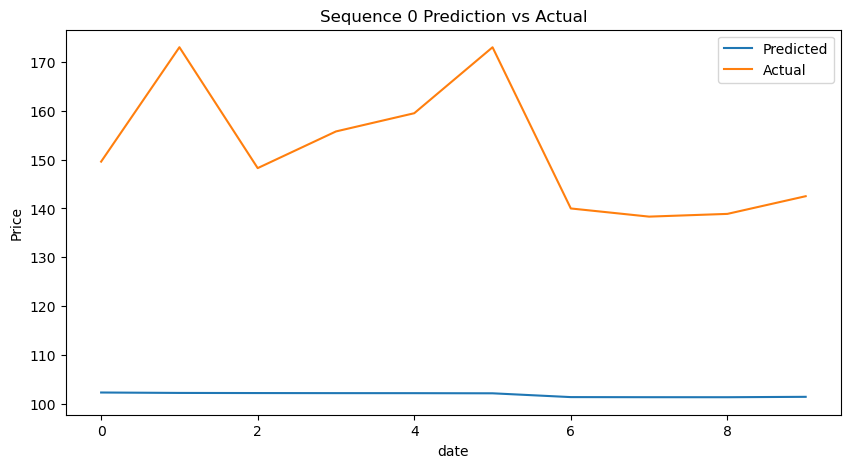

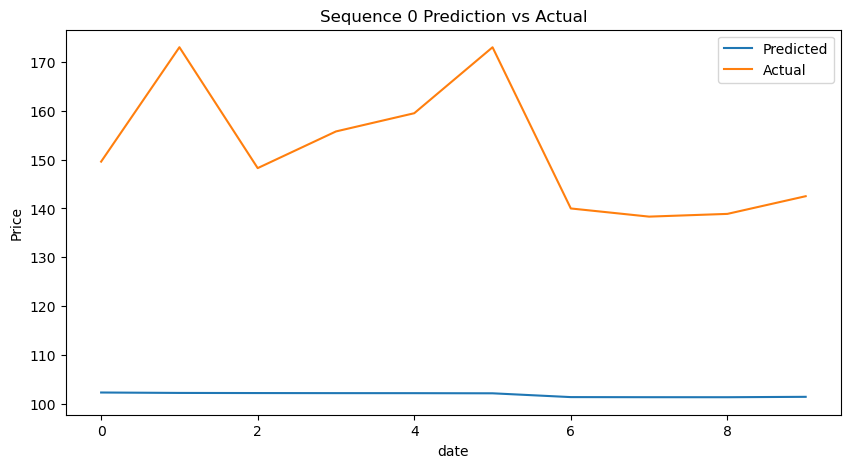

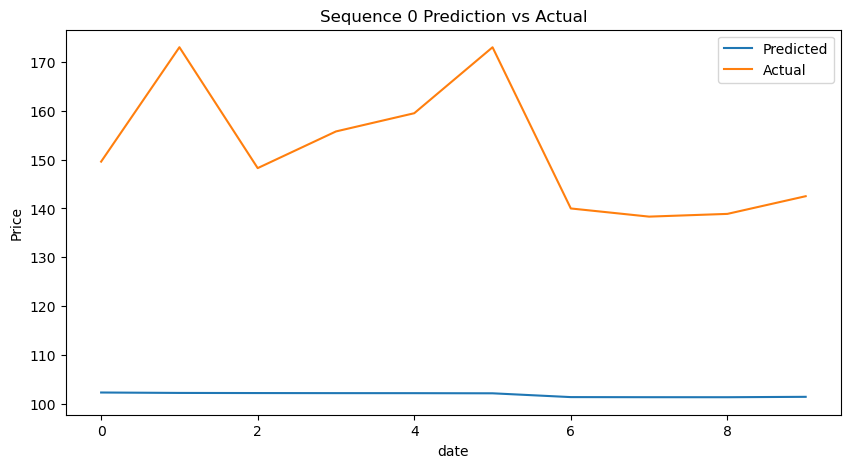

In [21]:
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy().squeeze()
    y_test_actual = y_test_tensor.cpu().numpy().squeeze()


import matplotlib.pyplot as plt

for i in range(10):
    i = 0  # 你可以選擇任何索引
    plt.figure(figsize=(10, 5))
    plt.plot(predictions[i], label='Predicted')
    plt.plot(y_test_actual[i], label='Actual')
    plt.xlabel('date')
    plt.ylabel('Price')
    plt.title(f'Sequence {i} Prediction vs Actual')
    plt.legend()
    plt.show()

# plt.figure(figsize=(15, 6))
# plt.plot(y_test_actual, label='real price')
# plt.plot(predictions, label='predict price')
# plt.xlabel('date')
# plt.ylabel('Price')
# plt.title('comparison')
# plt.legend()
# plt.show()

In [19]:
predictions.shape

(18411, 10)

In [18]:
results_df = pd.DataFrame({
    'Actual': y_test_actual,
    'Predicted': predictions
}, index=y_test.index[seq_length:])

ValueError: Data must be 1-dimensional, got ndarray of shape (18411, 10) instead

In [ ]:
# 单元格 2：定义绘图函数
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def plot_three_day_comparison(data, start_date, end_date):
    period_data = data.loc[start_date:end_date]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(period_data.index, period_data['Actual'], label='Actual price', marker='o', markersize=4)
    ax.plot(period_data.index, period_data['Predicted'], label='predict price', marker='o', markersize=4)
    
    ax.set_title(f'（{start_date.strftime("%Y-%m-%d %H:%M")} to {end_date.strftime("%Y-%m-%d %H:%M")}）')
    ax.set_xlabel('date')
    ax.set_ylabel('Price')
    ax.legend()
    

    ax.xaxis.set_major_locator(HourLocator(interval=6))
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
    plt.xticks(rotation=45)
    
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    

    mse = mean_squared_error(period_data['Actual'], period_data['Predicted'])
    mae = mean_absolute_error(period_data['Actual'], period_data['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(period_data['Actual'], period_data['Predicted'])
    
    metrics_text = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\n$R^2$: {r2:.4f}'
    plt.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()


from datetime import timedelta


start_date = results_df.index.min()
end_date = results_df.index.max()

current_date = start_date
while current_date <= end_date:
    period_end = min(current_date + pd.Timedelta(days=3), end_date)
    plot_three_day_comparison(results_df, current_date, period_end)
    current_date += pd.Timedelta(days=3)


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def is_prediction_successful(actual, predicted, tolerance=0.1):
    return abs(predicted - actual) <= abs(actual * tolerance)


results_df['is_successful'] = results_df.apply(lambda row: is_prediction_successful(row['Actual'], row['Predicted']), axis=1)


results_df['hour'] = results_df.index.hour
hourly_success_rate = results_df.groupby('hour')['is_successful'].mean().sort_values(ascending=False)


hourly_prediction_count = results_df.groupby('hour').size()


print("Hourly Success Rate (sorted from highest to lowest):")
print(hourly_success_rate)


plt.figure(figsize=(12, 6))
hourly_success_rate.plot(kind='bar')
plt.title('Prediction Success Rate by Hour (10% Tolerance)')
plt.xlabel('Hour of Day')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
hourly_prediction_count.plot(kind='bar')
plt.title('Number of Predictions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

top_5_hours = hourly_success_rate.nlargest(5)
bottom_5_hours = hourly_success_rate.nsmallest(5)

print("\nTop 5 hours with highest success rate:")
print(top_5_hours)

print("\nBottom 5 hours with lowest success rate:")
print(bottom_5_hours)

# 計算總體成功率
overall_success_rate = results_df['is_successful'].mean()
print(f"\nOverall Success Rate: {overall_success_rate:.2%}")


# fig, ax1 = plt.subplots(figsize=(15, 6))

# ax1.bar(hourly_success_rate.index, hourly_success_rate.values, alpha=0.7, color='b', label='Success Rate')
# ax1.set_xlabel('Hour of Day')
# ax1.set_ylabel('Success Rate', color='b')
# ax1.tick_params(axis='y', labelcolor='b')

# ax2 = ax1.twinx()
# ax2.plot(hourly_prediction_count.index, hourly_prediction_count.values, color='r', label='Prediction Count')
# ax2.set_ylabel('Number of Predictions', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# plt.title('Prediction Success Rate and Count by Hour')
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
# plt.tight_layout()
# plt.show()